# Europe PMC API introduction

In [1]:
import requests
import seaborn as sns
sns.set_theme()

API documentation can be found [here](https://europepmc.org/RestfulWebService).

## Searching

Searches use the `search` method. The `query` should be formatted just as you would format a query typed into the website.

The `query` below uses the query `"european hedgehog"`. The requested `format` is `json` and the `pageSize` is set to 1000 (the maximum).

In [2]:
query = '"european hedgehog"'
hh = requests.get(f"https://www.ebi.ac.uk/europepmc/webservices/rest/search?query={query}&format=json&pageSize=1000")
hh_hits = hh.json()

You can see the format of the result list below. You can get more information (including the abstract) in the results by setting the `resultType` parameter to `core`. The default is `lite`.

In [3]:
hh_hits['resultList']['result'][0]

{'id': '36946827',
 'source': 'MED',
 'pmid': '36946827',
 'pmcid': 'PMC10025996',
 'fullTextIdList': {'fullTextId': ['PMC10025996']},
 'doi': '10.1590/s1984-29612023014',
 'title': 'A new definitive host for Moniliformis cestodiformis (Acanthocephala: Moniliformidae): first report of a naturally infected European hedgehog (Erinaceus europaeus).',
 'authorString': 'Ramilo DW, Cruz JT, Amin O, Fragoso C, Brazio E, Correia J, Cardoso L, Fonseca IPD.',
 'journalTitle': 'Rev Bras Parasitol Vet',
 'issue': '1',
 'journalVolume': '32',
 'pubYear': '2023',
 'journalIssn': '0103-846x; 1984-2961; ',
 'pageInfo': 'e015022',
 'pubType': 'research-article; journal article',
 'isOpenAccess': 'Y',
 'inEPMC': 'Y',
 'inPMC': 'N',
 'hasPDF': 'Y',
 'hasBook': 'N',
 'hasSuppl': 'N',
 'citedByCount': 0,
 'hasReferences': 'Y',
 'hasTextMinedTerms': 'Y',
 'hasDbCrossReferences': 'N',
 'hasLabsLinks': 'N',
 'hasTMAccessionNumbers': 'N',
 'firstIndexDate': '2023-03-23',
 'firstPublicationDate': '2023-03-17'}

I could use this result list to plot the frequency of publications mentioning the European Hedgehog as follows

In [4]:
hh_pub_years = [int(hit['pubYear']) for hit in hh_hits['resultList']['result']]

<Axes: ylabel='Count'>

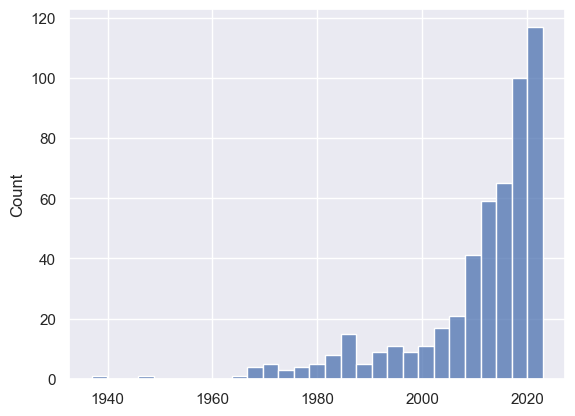

In [5]:
sns.histplot(data=hh_pub_years)

## Annotations

Perform a search as before

In [6]:
query = 'ndc80 interaction AND ((HAS_FT:Y AND OPEN_ACCESS:Y)) AND (FIRST_PDATE:2023)'
interactions = requests.get(f"https://www.ebi.ac.uk/europepmc/webservices/rest/search?query={query}&format=json&pageSize=100")
interactions_hits = interactions.json()

The annotations API only accepts 8 articles at a time. We'll use this method to batch the articles and send off multiple requests.

In [7]:
from itertools import islice
# https://docs.python.org/3/library/itertools.html#itertools-recipes
def batched(iterable, n):
    "Batch data into tuples of length n. The last batch may be shorter."
    # batched('ABCDEFG', 3) --> ABC DEF G
    if n < 1:
        raise ValueError('n must be at least one')
    it = iter(iterable)
    while batch := tuple(islice(it, n)):
        yield batch

In [8]:
from collections import Counter

For each article requested above, we'll get the annotations, batched together in groups of 8. I'm requesting `Experimental Methods` annotations found only in the `Methods` section.

In [9]:
# Annotations API accepts up to 8 articles at a time
annos = []
for batch in batched(interactions_hits['resultList']['result'], 8):
    ids = ','.join(f"{hit['source']}:{hit['id']}" for hit in batch)
    url = f"""https://www.ebi.ac.uk/europepmc/annotations_api/annotationsByArticleIds\
?articleIds={ids}\
&type=Experimental Methods\
&section=Methods"""
    batch_annos = requests.get(url)
    annos += batch_annos.json()

Each article has a list of annotations returned. Iterate through each of these and extract the experimental method that was found in the article. Using a `Counter` count how often each method is used.

In [10]:
methods_counter = Counter()
for article in annos:
    distinct_methods = {a['tags'][0]['name'].lower() for a in article['annotations']}
    methods_counter.update(distinct_methods)                               

Plot a barchart of each method that was found at least twice.

In [11]:
more_than_2 = {method: count for method, count in methods_counter.items() if count > 2}

<Axes: >

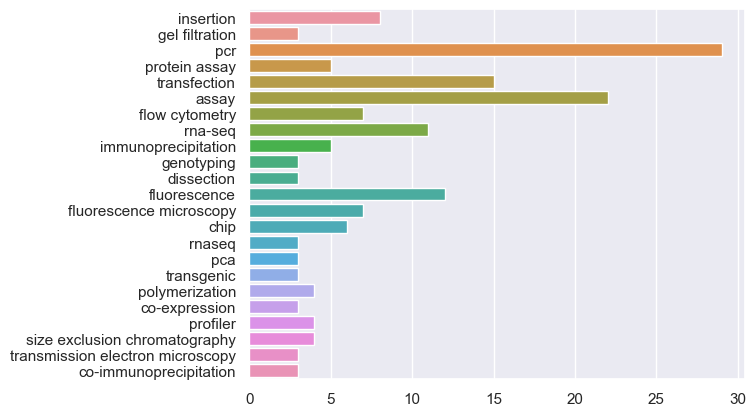

In [12]:
sns.barplot(y=list(more_than_2.keys()), x=list(more_than_2.values()))